![image](https://leasing.express/wp-content/uploads/2021/12/depozit-s-popolneniem.png)

# Проект-3: Классификация клиентов банка 

Для успешной работы над данным проектом нам потребуются следующие библиотеки:

In [2]:
# Чтение данных
import pandas as pd
import numpy as np

# Визуализация зависимостей и распределений в данных
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразование данных
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import MinMaxScaler

# Отбор признаков
from sklearn.feature_selection import SelectKBest, f_classif

# Разбиение данных
from sklearn.model_selection import train_test_split 

# Модели ML
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 

# Метрики
from sklearn import metrics 

# Игнорирование возможных предупреждений
import warnings
warnings.filterwarnings('ignore')

# Делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

## Знакомство с данными, обработка пропусков и выбросов

✍ Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу:

In [3]:
# Читаем данные и выводим первые пять строк с размерностью таблицы
df = pd.read_csv('data/bank_fin.csv', sep = ';')

print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# Выводим информацию об типах данных в признаках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


В первую очередь давайте выясним, есть ли в данных `пропущенные значения` (пустые, незаполненные ячейки)?

In [5]:
# Исследуем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum().sort_values(ascending=False)

balance      25
age           0
job           0
education     0
marital       0
default       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Мы выяснили количество пропущенных значений. Однако в данных обычно всё не так просто, и `пропущенные (неизвестные) значения` могут присутствовать `неявным образом`. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости).

Узнаем, каким именно словом закодированы `пропущенные (неизвестные) значения`:

In [6]:
# Проверяем признак на наличие 'неочевидных' пропусков в них
# Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Мы нашли `пропущенные значения`, и хотелось бы теперь их `обработать`. Однако мы не можем этого сделать, так как не все данные `представлены в корректном виде`.

Обратите внимание на признак `'balance'`: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число.

Обработаем значения этого признака так, чтобы он был преобразован в тип `float`:

In [7]:
# Преобразуем признак 'balance' таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ', '').replace(',', '.').replace('$', '')).astype(float)

Итак, значения в признаке `'balance'` приобрели `нормальный вид`, и теперь мы можем `обработать пропуски`, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: `заменим пропуски на медианное значение по этому признаку`:

In [8]:
# Обработаем пропуски в признаки 'balance', заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

Ранее мы выяснили, что в признаке `'job'` есть пропущенные значения, которые `не отображаются как пропуски в явном виде`. Однако нам всё равно важно их `обработать`. Мы знаем, что для категориальных признаков пропущенные значения лучше `заменить модой по данному признаку`.

Заменин все пропущенные значения в признаке `'job'` на модальные. То же самое сделаем с признаком, отвечающим за уровень образования:

In [9]:
# Обработаем пропуски в категориальных признаках: 'job' и 'education', заменив их на модальные значения признаков
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)

Изучим признак, отображающий баланс клиентов (`'balance'`), на предмет выбросов.

В `математической статистике` есть несколько подходов, позволяющих `определить наличие выбросов`. Мы будем считать, что выбросы `находятся за пределами отрезка`, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q1 - 1.5 * IQR$), а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. ($Q3 + 1.5 * IQR$).

Найдём эти границы, и отфильтруем значения так, чтобы выбросов в данных не осталось:

In [10]:
# Удалим все выбросы для признака 'balance' выходящие за рамки метода Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

print(f'Результирующее число записей: {cleaned.shape[0]}')

df = cleaned

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


⭐ Мы отлично справились с этой частью, а значит, можно переходить к `разведывательному анализу наших данных` →

## Разведывательный анализ данных

✍ В данной части проекта нам необходимо будет:

* Исследовать данные;

* Попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;

* Дополнить наш анализ визуализациями, иллюстрирующими наше исследование.

### Распределение целевой переменной

Давайте изучим `распределение целевой переменной`: есть ли несбалансированность классов?

Чтобы это определить, `вычислим частоты` для открывших депозит и для тех, кто его не открыл. Сопроводим числа диаграммой, отражающей полученные результаты:

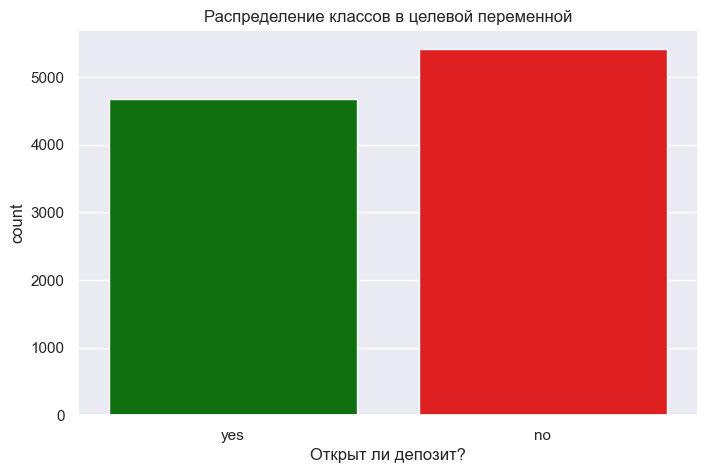

In [11]:
# Изучим соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируем результат
fig = plt.figure(figsize=(8, 5))

countplot = sns.countplot(
    data=df,
    x='deposit',
    hue='deposit',
    palette=['green', 'red']
)
countplot.set_title('Распределение классов в целевой переменной')
countplot.set_xlabel('Открыт ли депозит?');

In [12]:
# Выведем число наблюдений для каждой из категорий
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

In [13]:
# Выведем соотношение наблюдений для каждой из категорий
df['deposit'].value_counts(normalize=True)

deposit
no     0.536764
yes    0.463236
Name: proportion, dtype: float64

**Выводы по графику**: Как мы можем видеть, количество наблюдений для категории `'no'` больше, чем для клиентов открывших депозит. Это явно даёт нам знать об необходимости стратифицировать выборки по целевому признаку для более точного прогноза будущей модели. 

### Описательные статистики для количественных переменных

Начнём с `описательных статистик` для `количественных переменных`.

* Рассчитаем их и продумаем подробную интерпретацию.

* Попробуем описать данные, которые у нас есть и увидеть первые зависимости.

* Рассмотрим минимальные и максимальные значения.

* Посмотрим на меры разброса и оценим, насколько данные вариативны.

* Сравнив меры центральной тенденции, сделайем выводы о том, есть ли аномальные значения с меньшей или большей стороны.

* Дополним выводы визуализациями.

#### Распределение возраста клиентов банка

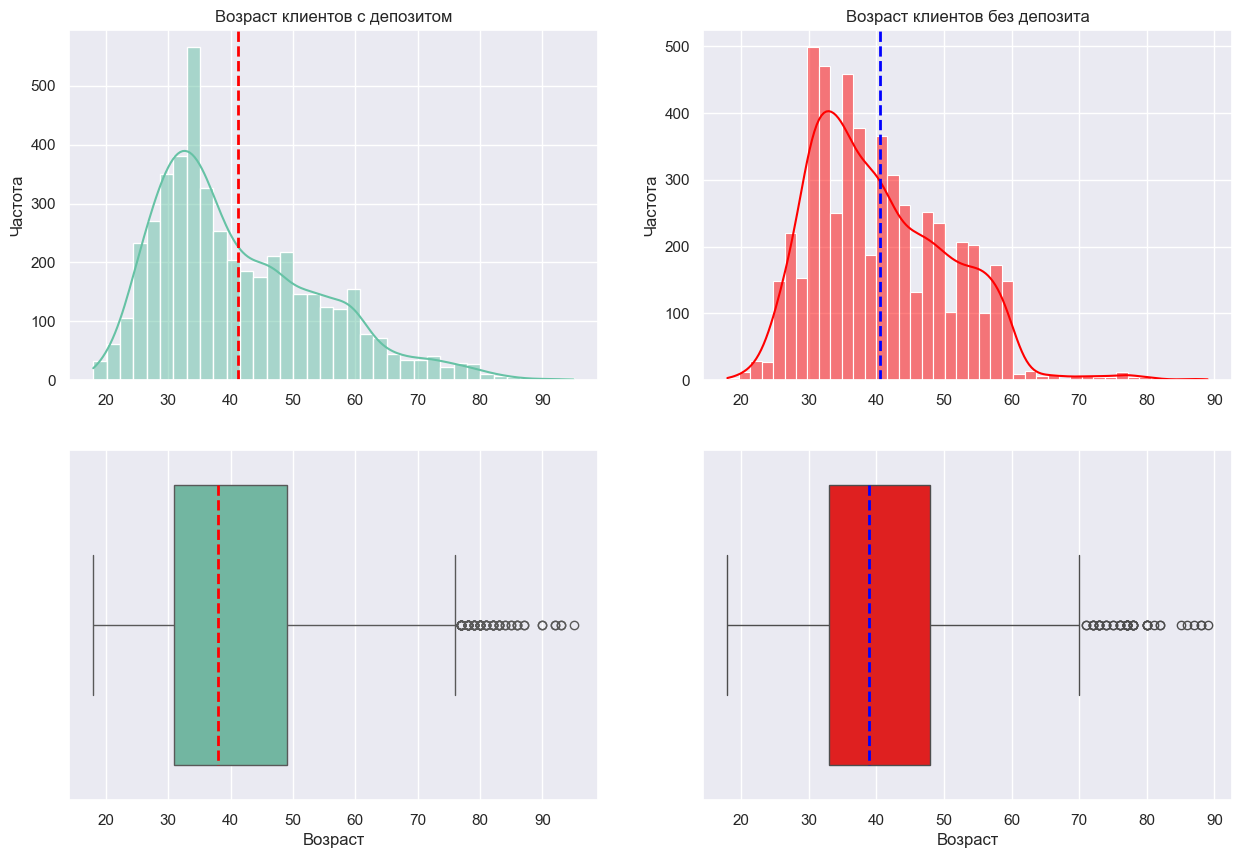

In [14]:
# Разделяем наши данные на клиентов с открытым депозитом и без него
opened_deposit = df[df['deposit'] == 'yes']
unopened_deposit = df[df['deposit'] == 'no']

# Отбираем возраст в каждой выбороке
age_distribution_with_opened_deposit = opened_deposit['age'].to_frame()
age_distribution_with_unopened_deposit = unopened_deposit['age'].to_frame()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Строим гистограмму распределения возраста клиентов с открытым депозитом
sns.histplot(data=age_distribution_with_opened_deposit['age'], kde=True, legend=False, ax=axes[0, 0])
axes[0, 0].set(xlabel = '', ylabel='Частота')
axes[0, 0].set_title('Возраст клиентов с депозитом')
axes[0, 0].axvline(age_distribution_with_opened_deposit['age'].mean(), color='red', linestyle='--', linewidth=2)

# Строим гистограмму распределения возраста клиентов без депозита
sns.histplot(data=age_distribution_with_unopened_deposit['age'], kde=True, legend=False, color='red', ax=axes[0, 1])
axes[0, 1].set(xlabel = '', ylabel='Частота')
axes[0, 1].set_title('Возраст клиентов без депозита')
axes[0, 1].axvline(age_distribution_with_unopened_deposit['age'].mean(), color='blue', linestyle='--', linewidth=2)

# Строим коробчатую диаграмму распределения возраста клиентов с открытым депозитом
sns.boxplot(data=age_distribution_with_opened_deposit['age'], ax=axes[1, 0], orient='h', medianprops={'color': 'red', 'linestyle': '--', 'linewidth': '2'})
axes[1, 0].set(xlabel='Возраст')

# Строим коробчатую диаграмму распределения возраста клиентов без депозита
sns.boxplot(data=age_distribution_with_unopened_deposit['age'], color='red', ax=axes[1, 1], orient='h', medianprops={'color': 'blue', 'linestyle': '--', 'linewidth': '2'})
axes[1, 1].set(xlabel='Возраст');

In [15]:
# Рассчитаем описательную статистику возраста для клиентов с открытым депозитом
age_distribution_with_opened_deposit['age'].describe()

count    4681.000000
mean       41.203162
std        13.291117
min        18.000000
25%        31.000000
50%        38.000000
75%        49.000000
max        95.000000
Name: age, dtype: float64

In [16]:
# Рассчитаем описательную статистику возраста для клиентов клиентов без депозита
age_distribution_with_unopened_deposit['age'].describe()

count    5424.000000
mean       40.629978
std        10.196686
min        18.000000
25%        33.000000
50%        39.000000
75%        48.000000
max        89.000000
Name: age, dtype: float64

**Выводы по графику**: Распределение возраста для клиентов двух категорий примерно одинаково, за исключением следующих факторов:

* Возраст клиентов с открытым депозитом находится в интервале `от 18 до 75 лет`, в отличие от клиентов не открывших депозит — `от 18 до 70 лет`;

* Мода значений обеих категорий равняется 32 годам для категории `deposit — 'yes'` и 31 году для `deposit — 'no'`;

* В обеих категориях признака наблюдаются выбросы (одиночные наблюдения) возраста после 76 лет для категории `deposit — 'yes'` и 70 лет для `deposit — 'no'`.

#### Распределение продолжительности разговора с клиентами банка

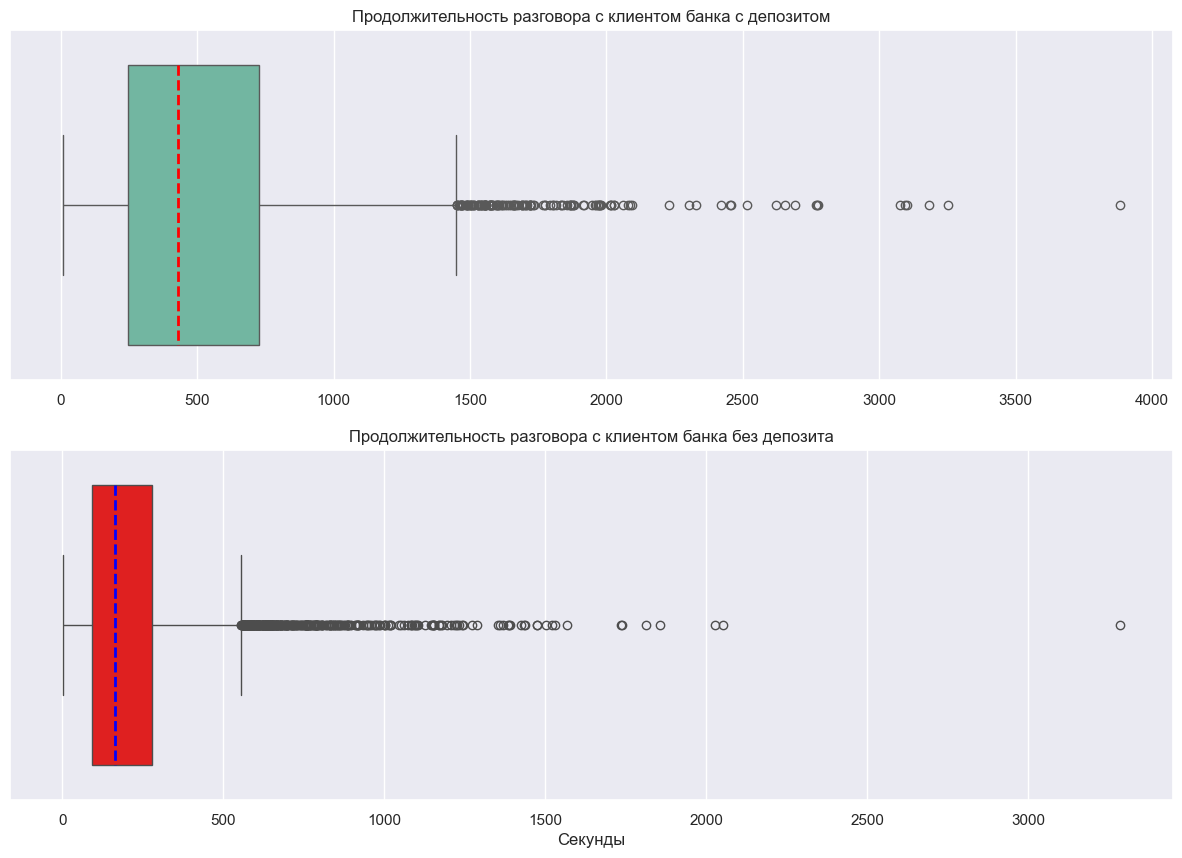

In [17]:
# Отбираем продолжительность разговора с клиентами банка в каждой выбороке
duration_distribution_with_opened_deposit = opened_deposit['duration'].to_frame()
duration_distribution_with_unopened_deposit = unopened_deposit['duration'].to_frame()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Строим коробчатую диаграмму распределения продолжительности разговора с клиентами с открытым депозитом
boxplot = sns.boxplot(data=duration_distribution_with_opened_deposit['duration'], orient='h', medianprops={'color': 'red', 'linestyle': '--', 'linewidth': '2'}, ax=axes[0])
axes[0].set(xlabel = '')
axes[0].set_title('Продолжительность разговора с клиентом банка с депозитом')

# Строим коробчатую диаграмму распределения продолжительности разговора с клиентами без депозита
boxplot = sns.boxplot(data=duration_distribution_with_unopened_deposit['duration'], orient='h', color='red', medianprops={'color': 'blue', 'linestyle': '--', 'linewidth': '2'}, ax=axes[1])
axes[1].set(xlabel = 'Секунды')
axes[1].set_title('Продолжительность разговора с клиентом банка без депозита');

In [18]:
# Рассчитаем описательную статистику продолжительности разговора для клиентов с открытым депозитом
duration_distribution_with_opened_deposit['duration'].describe()

count    4681.000000
mean      539.568896
std       394.408498
min         8.000000
25%       245.000000
50%       429.000000
75%       727.000000
max      3881.000000
Name: duration, dtype: float64

In [19]:
# Рассчитаем описательную статистику продолжительности разговора для клиентов без депозита
duration_distribution_with_unopened_deposit['duration'].describe()

count    5424.000000
mean      221.316740
std       206.688801
min         2.000000
25%        93.000000
50%       163.000000
75%       278.000000
max      3284.000000
Name: duration, dtype: float64

**Выводы по графику**: Первое, что бросается в глаза от распределений признака `duration` это интервал наблюдений для категории `deposit — 'no'` — он в несколько раз меньше, чем для клиентов, согласившихся открыть депозит в банке.

Можно сделать вывод о том, что клиенты соглашаются открыть депозит в банке при уделение гораздо большего времени для поддержания его лояльности по отношению к банку и его продуктам. В свою очередь, клиенты категории `deposit — 'no'` имеют обделение этим 'вниманием'.

Стоит взять во внимание этот признак, возможно, `увеличение времени диалога и/или введение стандартного времени поддержания диалога с клиентом для призентации банковских продуктов` поможет увеличить долю клиентов открывших депозит в банке.

### Описательные статистики для категориальных переменных

Теперь давайте рассмотрим `описательные статистики` для `категориальных переменных`.

Попробуем `извлечь максимум информации` из тех показателей, которые можем получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постараемся `дать достаточно подробную интерпретацию`, а для лучшей наглядности добавим визуализации по каждой категориальной переменной.

#### Распределение частоты контакта с клиентами в течении месяцев

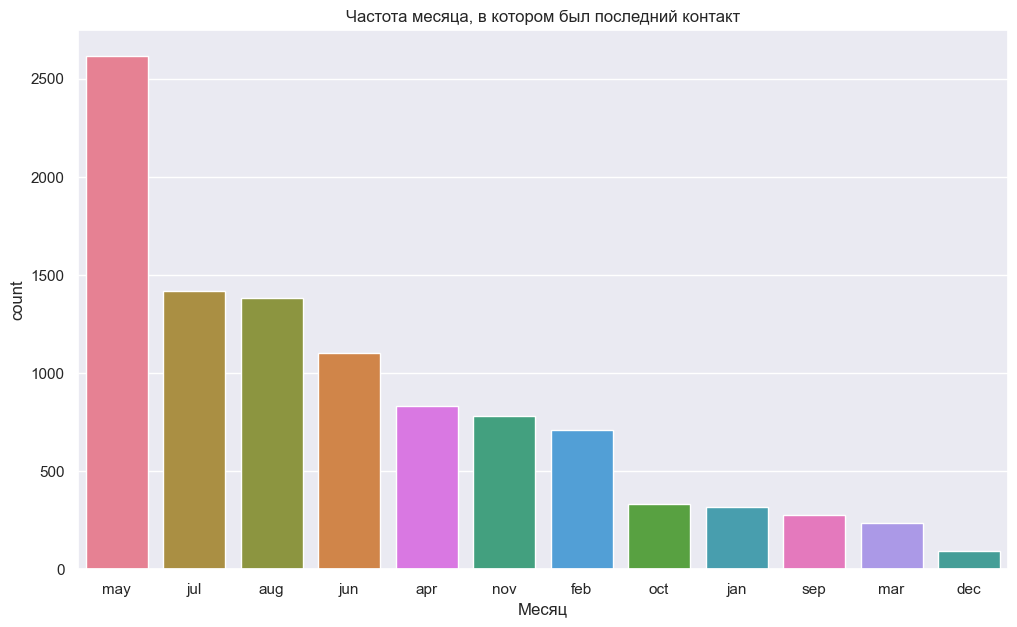

In [20]:
# Визуализируем частоту контакта с клиентами в течении месяца
fig = plt.figure(figsize=(12, 7))

countplot = sns.countplot(
    data=df,
    x='month',
    hue='month',
    order=df['month'].value_counts(ascending=False).index
)
countplot.set_title('Частота месяца, в котором был последний контакт')
countplot.set_xlabel('Месяц');

In [21]:
# Выведем точное количество клиентов с которыми был установлен контакт в течении каждого месяца
df['month'].value_counts()

month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64

**Выводы по графику**: Заметно, как `количество контактов с клиентами в мае преобладает` над остальными месяцами.

Это может быть связано с будущим летним отпуском — клиентам могут быть предложены банковские продукты на непредвиденные расходы в течении их отпуска или открытие депозита на минимальный период времени, для наблюдения первых накоплений за срок летних каникул/отпуска и привлечения клиентов продлить срок и/или сумму вложения денежных средств в банке.

#### Распределение сфер деятельности клиентов банка и их частота 

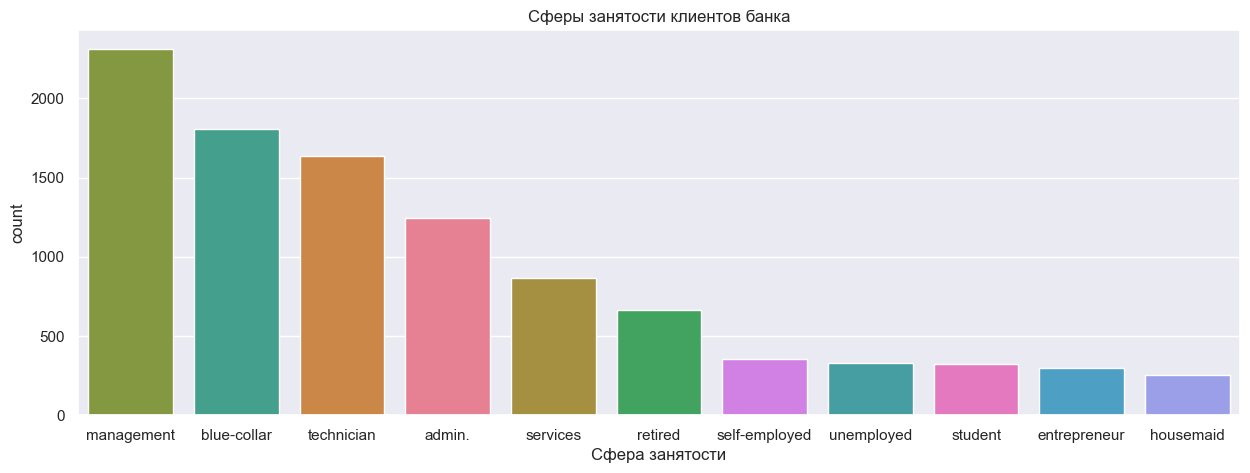

In [22]:
# Визуализируем сферу деятельности клиентов банка и их частоту
fig = plt.figure(figsize=(15, 5))

countplot = sns.countplot(
    data=df,
    x='job',
    hue='job',
    order=df['job'].value_counts(ascending=False).index,
)
countplot.set_title('Сферы занятости клиентов банка')
countplot.set_xlabel('Cфера занятости');

In [23]:
# Выведем точное количество наблюдений для каждой сферы деятельности клиентов
df['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

**Выводы по графику:** Самой `многочисленной же сферой деятельности` среди клиентов банка можно заслуженно считать категорию `'management'`, что неудивительно, кому как не сотрудникам, управляющими производствами, товарооборотом, предоставлением услуг в отделах или на предприятиях в целом знать о преимуществах долгосрочных перспектив продуктов и услуг банка и его услуг.

Можно сделать вывод, что именно на эту сферу деятельности у банка идёт `наибольший акцент` в привлечении клиентуры.

#### Распределение результатов текущей маркетинговой кампании и предыдущих

Теперь давайте узнаем, `есть ли разница в результатах текущей маркетинговой кампании и предыдущей`. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная.

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач:

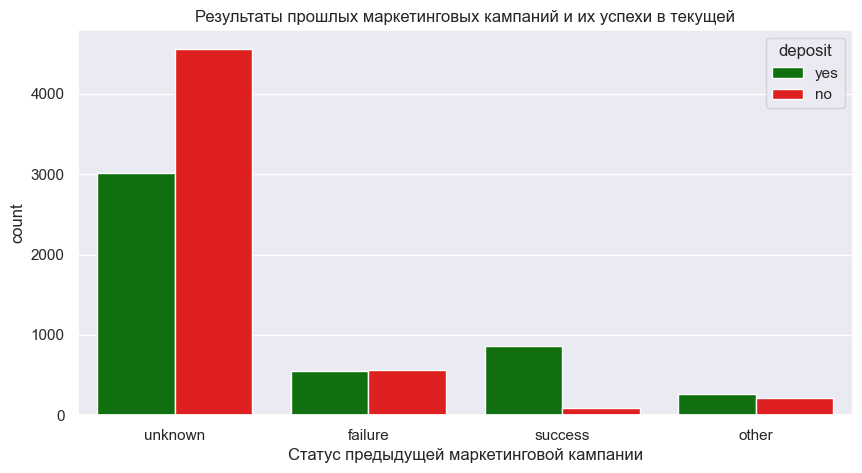

In [24]:
# Узнаем результаты прошлых маркетинговых кампаний и их успехи в привлечении клиентов в течении текущей
fig = plt.figure(figsize=(10, 5))

countplot = sns.countplot(
    data=df,
    x='poutcome',
    hue='deposit',
    palette=['green', 'red'],
    order=df['poutcome'].value_counts(ascending=False).index,
    legend=True
)
countplot.set_title('Результаты прошлых маркетинговых кампаний и их успехи в текущей')
countplot.set_xlabel('Статус предыдущей маркетинговой кампании');

In [25]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = df.pivot_table(
    index='poutcome',
    columns='deposit',
    values='age',
    aggfunc='count'
)
pivot

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


**Выводы по графику**: Как мы можем заметить, не смотря на то, что категория `'unknown'` имеет `наибольшее количество` клиентов согласившихся открыть депозит — 3008 человек, именно категория `'success'` имеет `наибольшую долю` успешно привлечённых клиентов в течении текущей маркетинговой кампании по сравнению с другими категориями признака:

* `'success'` — 0.91%

* `'other'` — 0.55%

* `'failure'` — 0.49%

* `'unknown'` — 0.39%

#### Распределение зависимости результатов маркетинговых кампаний от месяца

Теперь давайте узнаем, `какова зависимость результата маркетинговых кампаний от месяца`.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги:

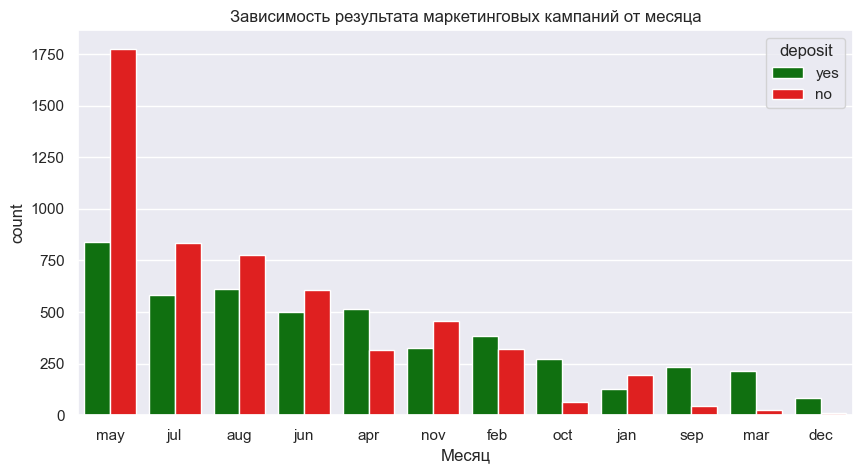

In [26]:
# Узнаем результаты (по месяцам) при взаимодействии с клиентами в течении текущей маркетинговой кампании
fig = plt.figure(figsize=(10, 5))

countplot = sns.countplot(
    data=df,
    x='month',
    hue='deposit',
    palette=['green', 'red'],
    order=df['month'].value_counts(ascending=False).index,
    legend=True
)
countplot.set_title('Зависимость результата маркетинговых кампаний от месяца')
countplot.set_xlabel('Месяц');

In [27]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = df.pivot_table(
    index='month',
    columns='deposit',
    values='age',
    aggfunc='count'
)
pivot

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


**Выводы по графику**: Как и в случае с частотой месяца, в котором был последний контакт с клиентом, `май` имеет как `наибольшее количество` успешно привлечённых к открытию депозита клиентов, так и неуспешно, что `напрямую зависило` от количества клиентов с которыми был контакт в течении этого месяца.

Но если обратить внимание на такие месяца, как `март, октябрь, сентябрь и декабрь` заметно `явное преобладание` клиентов, согласившихся к открытию депозита над отказавшимися, что может быть результатом `преддверия` к каким-то праздникам или памятным датам, что в свою очередь `влияет на решение` клиентов использовать банковские продукты.

#### Распределение возрастных групп и их склонность открывать депозит в банке

Нам бы очень хотелось посмотреть, `люди какого возраста чаще открывают депозиты`, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято `разделять людей по возрастным подгруппам` и делать выводы уже по ним.

Создадим новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

* `'<30'`;

* `'30-40'`;

* `'40-50'`;

* `'50-60'`;

* `'60+'`.

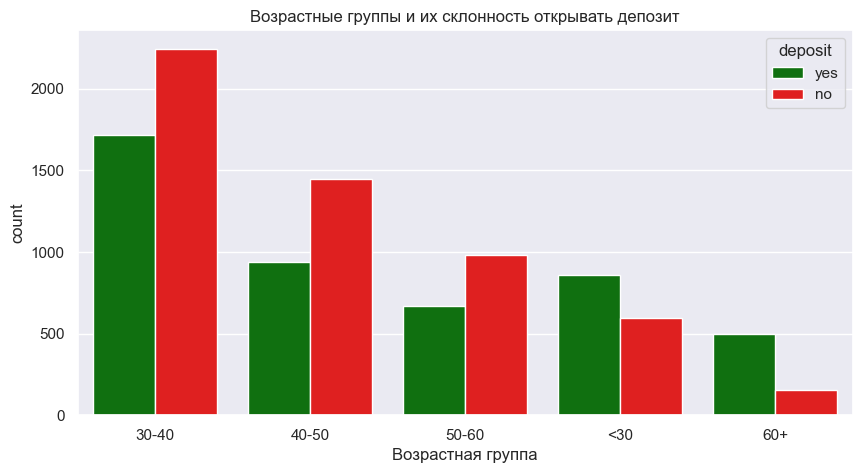

In [28]:
# Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age group'] = df['age'].apply(lambda x: '<30' if x < 30
                                  else '30-40' if x >= 30 and x < 40
                                  else '40-50' if x >= 40 and x < 50
                                  else '50-60' if x >= 50 and x < 60
                                  else '60+')

# Визуализируем полученные группы и их склонность открывать депозит в банке
fig = plt.figure(figsize=(10, 5))

countplot = sns.countplot(
    data=df,
    x='age group',
    hue='deposit',
    palette=['green', 'red'],
    order=df['age group'].value_counts(ascending=False).index,
    legend=True
)
countplot.set_title('Возрастные группы и их склонность открывать депозит')
countplot.set_xlabel('Возрастная группа');

In [82]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = df.pivot_table(
    index='age group',
    columns='deposit',
    values='age',
    aggfunc='count'
)
pivot

deposit,no,yes
age group,,
30-40,2245,1716
40-50,1444,938
50-60,984,670
60+,157,496
<30,594,861


In [83]:
# Выведем соотношение категорий целевого признака в зависимости от возрастной группы
df.groupby('age group')['deposit'].value_counts(normalize=True).to_frame()

proportion
age group deposit            
30-40     no         0.566776
          yes        0.433224
40-50     no         0.606213
          yes        0.393787
50-60     no         0.594921
          yes        0.405079
60+       yes        0.759571
          no         0.240429
<30       yes        0.591753
          no         0.408247

**Выводы по графику**: Из всех полученных нами возрастных групп, категории `'30-40'` и `'60+'` более склонны открывать депозит (по `количеству` для первой и `соотношению` для второй группы), чем отказываться от его открытия в банке после рекламного предложения:

* `Склонность` первой группы может быть охарактеризована наличием `детей, семейным положением и образованием` (оплата за которое чаще всего происходит именно в виде студенческого кредита), что и делает эту группу `склонной` чаще всего не отказываться от предложений банка.

* `Склонность` же второй группы (`'60+'`) может быть обусловлена [суммой пенсии для данной возрастной группы](https://pensionrights.org/resource/income-from-pensions/#:~:text=Median%20Pension%20Benefit&text=The%20median%20private%20pension%20benefit,benefit%20was%20%2424%2C980%20a%20year.), что так же `сподвигает` данный слой населения `чаще обращать внимание` на предложения банка и его услуги.

### Cоотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты

Давайте посмотрим, `как зависит соотношение успешных и неуспешных контактов с клиентами` от категорий, к которым относятся клиенты:

* семейное положение;

* уровень образования;

* сфера занятости.

Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков.

Выясним, к каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

#### Распределение сфер деятельности и их занятось клиентами банка

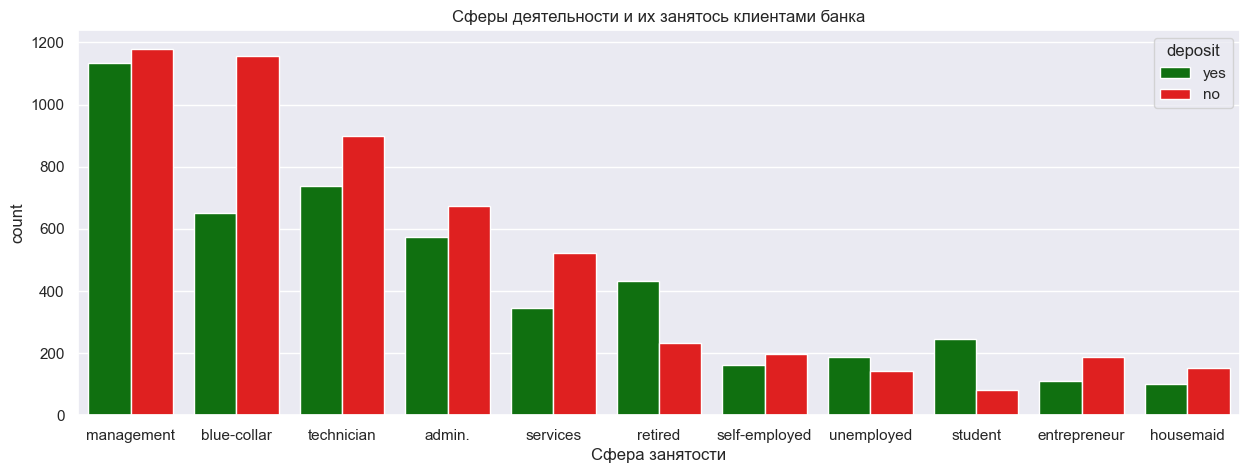

In [84]:
# Построим визуализации для открывших и неоткрывших депозит клиентов в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(15, 5))

countplot = sns.countplot(
    data=df,
    x='job',
    hue='deposit',
    palette=['green', 'red'],
    order=df['job'].value_counts(ascending=False).index,
    legend=True
)
countplot.set_title('Сферы деятельности и их занятось клиентами банка')
countplot.set_xlabel('Cфера занятости');

In [85]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = df.pivot_table(
    index='job',
    columns='deposit',
    values='age',
    aggfunc='count'
)
pivot

deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245


**Выводы по графику**: Как мы `убедились ранее и подтверждаем сейчас`, категория сферы деятельности `'management'` имеет `наибольшее число` среди всех клиентов банка, имея примерно `одинаковую тенденцию` как отказываться так и соглашаться на предложения банка и его услуг, что делает эту категорию `наиболее прибыльной` среди всех представленных нам сфер деятельности клиентов.

#### Распределение уровней образования и их занятось клиентами банка

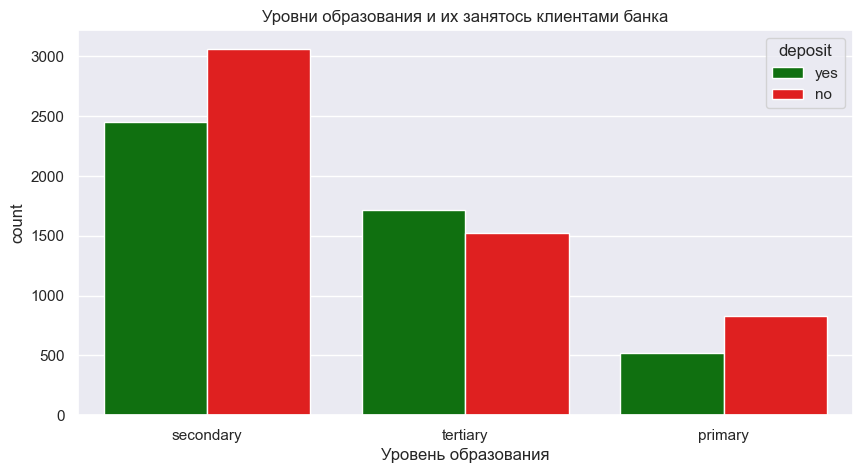

In [86]:
# Построим визуализации для открывших и неоткрывших депозит клиентов в зависимости от уровня образования
fig = plt.figure(figsize=(10, 5))

countplot = sns.countplot(
    data=df,
    x='education',
    hue='deposit',
    palette=['green', 'red'],
    order=df['education'].value_counts(ascending=False).index,
    legend=True
)
countplot.set_title('Уровни образования и их занятось клиентами банка')
countplot.set_xlabel('Уровень образования');

In [87]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = df.pivot_table(
    index='education',
    columns='deposit',
    values='age',
    aggfunc='count'
)
pivot

deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713


**Выводы по графику**: Из категорий образования, `наибольшую долю занятости клиентами банка` занимают категории `'secondary'` и `'tertiary'`, на что мы также `обращали внимание` при анализе признака возрастных групп (признак `age_group`) – оплата за образование чаще всего происходит именно в виде `студенческого кредита`, ввиду зачастую большой величины стоимости высшего образования.

#### Распределение семейного положения и его занятось клиентами банка

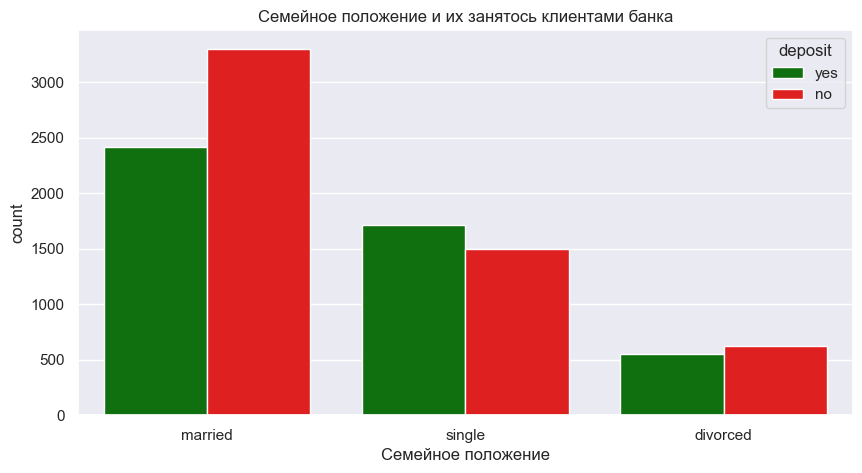

In [88]:
# Построим визуализации для открывших и неоткрывших депозит клиентов в зависимости от их семейного статуса
fig = plt.figure(figsize=(10, 5))

countplot = sns.countplot(
    data=df,
    x='marital',
    hue='deposit',
    palette=['green', 'red'],
    order=df['marital'].value_counts(ascending=False).index,
    legend=True
)
countplot.set_title('Семейное положение и их занятось клиентами банка')
countplot.set_xlabel('Семейное положение');

In [89]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = df.pivot_table(
    index='marital',
    columns='deposit',
    values='age',
    aggfunc='count'
)
pivot

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


**Выводы по графику**: Среди представленных нам категорий семейного положения `тенденция открывать депозит`, а не отказываться от его открытия наблюдается у группы `'single'`, у категории `'married'` наблюдается именно `наибольшее количество` открытых депозитов по сравнению с другими группами:

* `Склонность` 'одиночек' может быть явно связана с `необходимостью в тратах`, которые один человек часто может себе `не позволить`, что и делает эту группу `более склонной к открытию депозита` и лояльной по отношению к продуктам банка.

* Наличие `преобладающего количества` открытых депозитов среди группы `женатых и замужних групп граждан` так же может быть `напрямую взаимосвязанно` с наличием детей, образованием и прочими тратами, с которыми сталкиваются пары при совместной жизни, от чего и возникает `необходимость` в использовании банковских предложений и открытия депозита для будущих непредвиденных расходов.   

#### Распределение пересечений категорий образования и семейного положения

Ранее мы `посмотрели различные категории отдельно`. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению. Результаты представим в виде тепловых карт. 

Посмотрим, различаются ли наиболее популярные группы для открывших депозит и для неоткрывших, а так же какой вывод можно сделать, исходя из полученных данных?

In [90]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = opened_deposit.pivot_table(
    values= 'deposit',
    index= 'education',
    columns= 'marital',
    aggfunc='count'
)
pivot

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


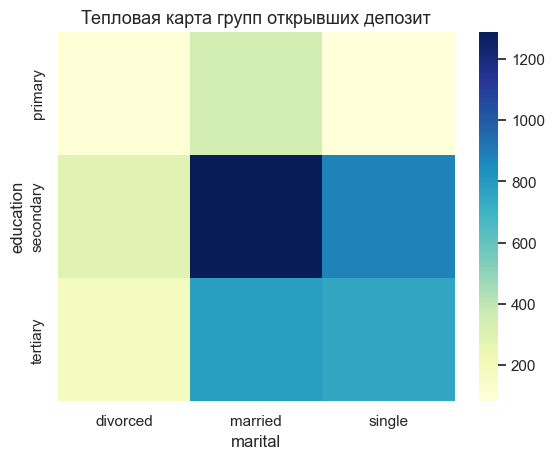

In [91]:
# Визуализируем полученную сводную таблицу в виде тепловой карты
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта групп открывших депозит', fontsize=13);

In [92]:
# Создадим сводную таблицу чтобы узнать точное число наблюдений для каждого пересечения категорий
pivot = unopened_deposit.pivot_table(
    values= 'deposit',
    index= 'education',
    columns= 'marital',
    aggfunc='count'
)
pivot

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


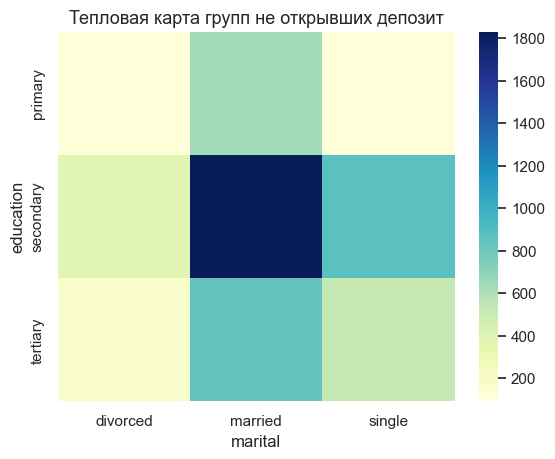

In [93]:
# Визуализируем полученную сводную таблицу в виде тепловой карты
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта групп не открывших депозит', fontsize=13);

**Выводы по графикам**: Закрепляя наши наблюдения касательно семейного положения и категорий образования у групп граждан, пересечение категорий `'secondary'` и `'married'` в обеих выборках являются `самыми многочисленными`.

Не смотря на это у нас `нет оснований утверждать`, что у граждан на пересечении данных категорий есть явная тенденция чаще соглашаться на предложения банка.

Тем не менее, `количество наблюдений` для пересечения данных категорий в выборке `opened_deposit` заметно `преобладают над остальными представленными категориями`. В свою очередь это указывает на то, что по сравнению с другими группами, клиенты на пересечении категорий `'secondary'` и `'married'` чаще остальных `соглашаются на предложения банка`.

⭐ Мы справились с `разведывательным анализом` и уже кое-что знаем о наших данных: теперь мы понимаем, какие в целом клиенты обслуживаются в банке, а также знаем, какие возрастные и социальные группы склонны чаще соглашаться на предложение банка.

## Преобразование данных

✍ Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

* Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.

* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.

* Надо отобрать признаки, которые мы будем использовать для обучения модели.

Начнём с `обработки категориальных порядковых признаков`.

Обработаем их с помощью метода `LabelEncoder`, используя метод без дополнительных настроек:

In [94]:
# Преобразуем бинарные переменные в представление из нулей и единиц
le = LabelEncoder()
df['education'] = le.fit_transform(y=df['education'])
df['deposit'] = le.fit_transform(y=df['deposit'])
df['default'] = le.fit_transform(y=df['default'])
df['housing'] = le.fit_transform(y=df['housing'])
df['loan'] = le.fit_transform(y=df['loan'])
df['age group'] = le.fit_transform(df['age group'])

Теперь нам необходимо `преобразовать номинальные переменные`, которые могут принимать несколько различных значений. Это следующие переменные:

* `'job'`;

* `'marital'`;

* `'contact'`;

* `'month'`;

* `'poutcome'`.

Создадим для них *dummy*-переменные и добавим их в набор данных:

In [95]:
# Создаём dummy-переменные для необходимых признаков
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

Теперь давайте `оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной`. Для этого построим матрицу корреляций:

In [96]:
# Построим корреляционную матрицу для оценки данныых на предмет наличия мультиколлинеарности
correlation_matrix  = df.corr()
correlation_matrix['deposit'].sort_values(ascending=False)

deposit              1.000000
duration             0.457818
poutcome_success     0.288491
contact_cellular     0.223944
pdays                0.147917
previous             0.141102
age group            0.136243
balance              0.135893
month_mar            0.135348
month_oct            0.130599
month_sep            0.125239
job_student          0.105563
job_retired          0.100090
education            0.098253
marital_single       0.097005
month_apr            0.092888
month_dec            0.085041
month_feb            0.044728
poutcome_other       0.039319
job_unemployed       0.039196
job_management       0.029566
age                  0.024357
poutcome_failure     0.021124
contact_telephone    0.007064
marital_divorced     0.004808
job_admin.          -0.001927
job_self-employed   -0.005194
month_jun           -0.008533
job_technician      -0.011190
month_aug           -0.018225
job_housemaid       -0.022572
month_jan           -0.025847
month_nov           -0.027754
job_entrep

Теперь нам необходимо `определить целевую переменную и предикторы`, а также `разделить выборку на обучающую и тестовую`.

При разбиении задим параметр `random_state` = 42, а размер тестовой выборки возьмите за `0.33`. Не забудем так же добавить аргумент, определяющий сохранение соотношений целевого признака:

In [97]:
# Определяем 'X' — предикторы и 'y' — целевую переменную 
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
# Разделяем выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [98]:
# Рассчитаем показатели размерности в выборках
print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (6770, 45)
Размер тестовой выборки: (3335, 45)


На данный момент у нас `достаточно много признаков`: скорее всего, `не все из них будут важны`. Давайте оставим лишь те, которые `сильнее всего связаны с целевой переменной` и `точно будут вносить вклад в повышение качества модели`.

С помощью `SelectKBest` отберём 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйем по обучающей выборке, используя параметр `score_func = f_classif`.

**Важно помнить, что на данном этапе нам необходимо оставить только те признаки, которые содержат лишь числовые значения!**

In [99]:
# Создаём объект класса 'SelectKBest' и обучаем его на тестовой выборке
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

# Для удобства упаковываем полученный массив из признаков в переменную
features = selector.get_feature_names_out()

# Для проверки результата выведем полученный массив
features

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [100]:
# Преобразуем наши предикторы в выборках на основе найденных методом признаков 
X_train = X_train[features]
X_test = X_test[features]

Теперь данные необходимо `нормализовать`.

Есть разные варианты нормализации, но мы будем использовать *min-max*-нормализацию.

**Не забываем, что нормализация требуется для предикторов, а не для целевой переменной!**

Нормализуем предикторы в обучающей и тестовой выборках:

In [101]:
# Нормализуем данные с помощью класса 'MinMaxScaler'
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

⭐ Мы успешно отобрали самые значимые для наших моделей признаки и преобразовали наши выборки, а значит, мы готовы к самому ответственному этапу нашего проекта — `решении задачи классификации` →

## Решение задачи классификации: логистическая регрессия и решающие деревья

✍ Настало время классификации!

Для начала реализуем самый простой алгоритм, который нам известен — `логистическую регрессию`. В качестве `алгоритма оптимизации` будем использовать `'sag'`, в качестве значения параметра `random_state` возьмём число 42 и запустим 1000 `итераций`.

Оценим качество модели на тестовой выборке:

In [102]:
# Обучим логистическую регрессию и рассчитаем метрики качества — 'accuracy'
lr = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)

lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f'Accuracy на тренировочной выборке: {np.round(metrics.accuracy_score(y_train, y_train_pred), 2)}')
print(f'Accuracy на тестовой выборке: {np.round(metrics.accuracy_score(y_test, y_test_pred), 2)}')

Accuracy на тренировочной выборке: 0.82
Accuracy на тестовой выборке: 0.8


Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — `решающие деревья`. В качестве параметров для начала возьмём следующие:

* `criterion = 'entropy'`;

* `random_state = 42`.

Остальные параметры оставим по умолчанию:

In [103]:
# Обучим решающие деревья и рассчитаем метрики качества
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

print('Train:')
print(metrics.classification_report(y_train, y_train_pred))
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))

Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Test:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Переберём различные `максимальные глубины деревьев` и найдём `глубину дерева`, для которой будет максимальное значение метрики *`accuracy`*, но при этом ещё не будет наблюдаться `переобучения` (т.е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой):

In [104]:
# С помощью 'GridSearchCV' подберём максимальную глубину дерева
from sklearn.model_selection import GridSearchCV

# Задаём сетку подбираемого параметра
param_grid = {'max_depth': list(np.linspace(2, 10, 5, dtype=int))} # Максимальная глубина дерева

# Создаём объект класса `RandomizedSearchCV`
grid_search = GridSearchCV(
    estimator=dt, # Передаём нашу модель
    param_grid=param_grid, # Сетку искомых параметров
    n_jobs=-1 # `n_jobs = -1`, чтобы использовать все доступные ядра для расчётов
)

# Обучаем объект `RandomizedSearchCV` на тренировочной выборке
grid_search.fit(X_train, y_train) 
# Делаем предсказание на тренировочной и тестовой выборке
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
# Выводим значения метрик и гиперпараметров
print('Train:')
print(metrics.classification_report(y_train, y_train_pred))
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))

Train:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.82      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Test:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Наилучшие значения гиперпараметров: {'max_depth': np.int64(8)}


Разумеется, у каждой модели может быть `множество параметров`. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем `использовать оптимизацию`: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуем `оптимизацию гиперпараметров` с помощью *`GridSearch`*, перебрав следующие параметры:

* `'min_samples_split': [2, 5, 7, 10]`;

* `'max_depth': list(np.linspace(2, 10, 5, dtype=int))`.

In [105]:
# Дополнительно подберём 'min_samples_split' с помощью 'GridSearchCV'
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': list(np.linspace(2, 10, 5, dtype=int))
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs=-1
)

grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print('Train:')
print(metrics.classification_report(y_train, y_train_pred))
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))

Train:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.82      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Test:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Наилучшие значения гиперпараметров: {'max_depth': np.int64(8), 'min_samples_split': 10}


⭐ По сути, мы уже решили задачу `классификации`: отобрали признаки, обучили модель, сделали прогноз и оценили его качество. Однако не будем останавливаться на достигнутом — `попробуем более сложные модели и варианты оптимизации` →

## Решение задачи классификации: ансамбли моделей и построение прогноза

✍ Мы уже `смогли обучить несложные модели`, и теперь пришло время `усложнить их`, а также посмотреть, улучшится ли результат (и если да, то насколько).

Мы обучили `решающие деревья`, и теперь пришла пора объединить их в `случайный лес`:

Обучим `случайный лес` со следующими параметрами:

* `n_estimators = 100`;

* `criterion = 'gini'`;

* `min_samples_leaf = 5`;

* `max_depth = 10`;

* `random_state = 42`.

In [106]:
# Обучим случайный лес с имеющимися параметрами
rf = ensemble.RandomForestClassifier(
    n_estimators=100, # Количество деревьев в лесу
    criterion='gini', # Критерий информативности
    min_samples_leaf=5, # Минимальное количество объектов в листе
    max_depth=10, # Максимальная глубина дерева
    random_state=42 # Воспроизводимость результатов
)

rf.fit(X_train, y_train)

# Делаем предсказание на тренировочной и тестовой выборке
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
# Выводим значения метрик
print('Train:')
print(metrics.classification_report(y_train, y_train_pred))
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))

Train:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Test:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаю вам сравнить полученные результаты с моделью `градиентного бустинга`. Используйем `градиентный бустинг` для решения задачи `классификации`, задав для него следующие параметры:

* `learning_rate = 0.05`;

* `n_estimators = 300`;

* `min_samples_leaf = 5`;

* `max_depth = 5`;

* `random_state = 42`.

In [107]:
# Используем для классификации градиентный бустинг и сравним качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.05, # Темп обучения
    n_estimators=300, # Число деревьев в 'лесу'
    min_samples_leaf=5, # Минимальное количество объектов в листе
    max_depth=5, # Максимальная глубина дерева
    random_state=42 # Воспроизводимость результатов
)

gb.fit(X_train, y_train)

# Делаем предсказание на тренировочной и тестовой выборке
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)
# Выводим значения метрик
print('Train:')
print(metrics.classification_report(y_train, y_train_pred))
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))

Train:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Test:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Мы уже попробовали построить разные модели, и теперь пришло время построить `ансамбль` из моделей разного типа.

В этом раз нам будет необходимо использовать `стекинг`, объединив те алгоритмы, которые мы уже использовали ранее: `решающие деревья, логистическую регрессию и градиентный бустинг`. В качестве `метамодели` используем `модель логистической регрессии`.

Параметры оставим те же, что были в наших алгоритмах ранее:

In [108]:
# Объединим уже известные нам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier

# Создаём список кортежей вида: (наименование модели, модель(её параметры))
estimators = [
    ('df', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=8,
        min_samples_split=10,
        random_state=42)),
    ('lr', linear_model.LogisticRegression(
        solver='sag',
        max_iter=1000,
        random_state=42)),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42))
]

# Создаём объект класса 'StackingClassifier'
stack_reg = StackingClassifier(
    estimators=estimators, # Наши рамодели
    # Метамодель
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        max_iter=1000,
        random_state=42)
)

# Обучаем модель
stack_reg.fit(X_train, y_train)

# Формируем предсказание для тренировочной и тестовой выборки и оцениваем качество модели
y_train_pred = stack_reg.predict(X_train)
y_test_pred = stack_reg.predict(X_test)
print('Train:')
print(metrics.classification_report(y_train, y_train_pred))
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))

Train:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Test:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Разумеется, `не все признаки одинаково хорошо предсказывают результат маркетинговой кампании`. Для того чтобы отобрать наиболее значимые для нас `аспекты`, на которые надо будет обратить внимание при реализации следующей акции, давайте `выберем три признака, дающих наибольший вклад`:

In [113]:
# Оценим, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
selector = SelectKBest(f_classif, k=3)
selector.fit(X, y)
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

Ранее мы уже рассматривали `оптимизацию гиперпараметров` при помощи `GridSearch`. Однако мы знаем, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк `Optuna`. Применим его для `оптимизации гиперпараметров`. Для перебора возьмём `случайный лес` и следующие параметры:

* `n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)`;

* `max_depth = trial.suggest_int('max_depth', 10, 30, 1)`;

* `min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)`.

In [58]:
import optuna

# Реализуем оптимизацию гиперпараметров с помощью 'Optuna'
def optuna_rf(trial):
    # Задаём пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаём модель
    rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         min_samples_leaf=min_samples_leaf)
    
    rf.fit(X_train, y_train)
    score = metrics.f1_score(y_test, rf.predict(X_test))
    return score

# Создаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction='maximize'
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров 'n_trials' раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-09-25 14:33:30,907] A new study created in memory with name: RandomForestClassifier
[I 2024-09-25 14:33:31,308] Trial 0 finished with value: 0.8189873417721519 and parameters: {'n_estimators': 149, 'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8189873417721519.
[I 2024-09-25 14:33:31,798] Trial 1 finished with value: 0.8140195768866435 and parameters: {'n_estimators': 179, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8189873417721519.
[I 2024-09-25 14:33:32,289] Trial 2 finished with value: 0.8148148148148148 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8189873417721519.
[I 2024-09-25 14:33:32,761] Trial 3 finished with value: 0.817435249526216 and parameters: {'n_estimators': 175, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8189873417721519.
[I 2024-09-25 14:33:33,206] Trial 4 finished with value: 0.8163394553514883 and parameters: {'n_

In [59]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study.best_params))
print('F1_score на тестовом наборе: {:.2f}'.format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 141, 'max_depth': 17, 'min_samples_leaf': 5}
F1_score на тестовом наборе: 0.82


In [60]:
# Создаём и обучаем модель с полученными параметрами
rf = ensemble.RandomForestClassifier(**study.best_params, random_state=42)

rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Итоговый вывод по проекту

Оценив все наши модели в деле, мы можем прийти к выводу, что наилучшей из всех представленных нами моделей является `метод случайного леса` (он же `RandomForestClassifier`), со следующими параметрами, подобранными с помощью фреймворка — `Optuna`:

* `n_estimator` (количество деревьев в лесу) — 141;

* `criterion` (критерий информативности разбиения для каждого из деревьев) — `'gini'` (по умолчанию);

* `max_depth` (максимальная глубина дерева) — 17;

* ``min_samples_split'` (минимальное число объектов, при котором выполняется расщепление) — 2 (по умолчанию);

* `min_samples_leaf` (минимальное число объектов в листе) — 5;

* `max_features` (максимальное число признаков, которые будут использоваться каждым из деревьев) — `'sqrt'` (по умолчанию);

* `random_state` (воспроизводимость результатов) — 42;

  Остальные малозначимые параметры мы оставили в режиме по умолчанию.

Полученная с данными параметрами модель отлично охватывает как можно больше объектов положительного класса (`'deposit' — 1`) и чуть менее хорошо отделяет класс 1 от класса 0 (всё тот же признак `'deposit'`) и имеет точность в определении класса в 83%.

В качестве `рекомендаций банку` в проведении дальнейших маркетинговых кампаний мы можем посоветовать `обратить внимание` на следующую информацию о клиентах:

* Баланс клиента;

* Наличие кредита на жильё;

* Количество контактов с клиентом в течении маркетинговой кампании;

* Количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании;

* Количество контактов до текущей кампании;

* Возрастная группа клиента;

* Какое количество времени уделяется сотрудником при контаке с клиентои;

* Удалось ли связаться с клиентом;

* Вид контакта с клиентом;

* Месяц проведения маркетинговой кампании;

* Успешность прошлой маркетинговой кампании.